# Steps in PCA:
1. Get data X (n*p dimension)
2. Get covariance matrix (p*p dimension)
3. Do eigendecomposition that would give pair of eigenvalues (p dimension vector) and eigenvectors (p*p dimension vector)
4. We can sort eigenpairs by descending order of eigenvalues
5. Collect the two eigenvectors (or more) that correspond to the two largest eigenvalues, to capture about most of the variance in this dataset. Get more eigenvectors to capture more variance.
6. This would create a n*2-dimensional projection matrix W from the top two eigenvectors.
7. Using the projection matrix, we can now transform entire training dataset  onto the PCA subspace (the principal components one and two) obtaining x′, now a two-dimensional sample vector consisting of two new features by calculating dot product of projection matrix W and dataset X. This transformed dataset would be n*2 dimensional dataset.
 

In [25]:
# importing libaries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [26]:
# wine datset in the UCI Machine Learning Repository
df_wine = pd.read_csv('/Users/rishi/Desktop/wine.data',header=None)

In [27]:
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [28]:
# spliting the wine datset into training and testing sets
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    stratify=y, random_state=0
)

# standardizing the features using standard scaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test) 

In [29]:
# calaculating covaraince matrix using numpy
cov_mat = np.cov(X_train_std.T)

#getting eigenvalues and eigenvectors using numpy linear algebra functions
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

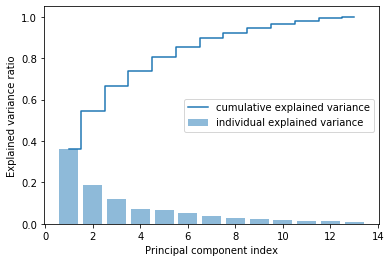

In [30]:
# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,14), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [31]:
# list of (eigenvalue, eigenvector) tuples and sorting them
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [32]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.14613334  0.48891111]
 [ 0.24163339  0.20255781]
 [-0.01922447  0.31020332]
 [ 0.2116175  -0.02169727]
 [-0.13767223  0.30359872]
 [-0.39729115  0.05790657]
 [-0.4210088  -0.01056952]
 [ 0.29952043  0.07884524]
 [-0.3060224   0.0391434 ]
 [ 0.07265891  0.54572871]
 [-0.32542869 -0.21901118]
 [-0.36839187 -0.21388626]
 [-0.30134127  0.35821848]]


In [33]:
# transforming the entire training dataset onto the two principal components by calculating the matrix dot product
X_train_pca = X_train_std.dot(w)

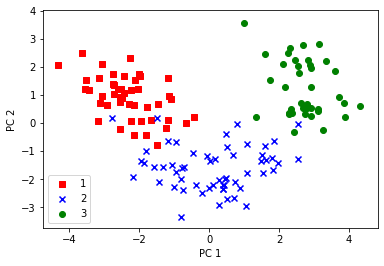

In [34]:
# visualizing the transformed Wine training set in a two-dimensional scatterplot
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

As we see, data is more spread along PC1 than PC2, which is consistent with the explained variance ratio plot (40% vs 20%). Any, linear classifier should be able to separate the classes easily.

### PCA using scikit-learn

In [35]:
# 2 component PCA and logistic regression 
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='auto', solver='liblinear')

# fit and transform data
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

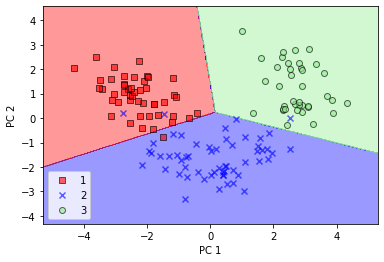

In [36]:
#visualizing decison regions
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)# plot decision regions for training set


plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

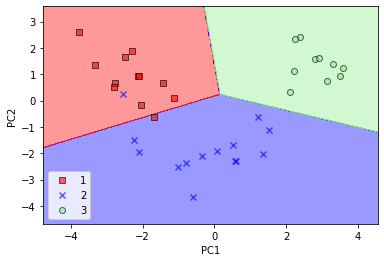

In [37]:
# plot decision regions for test set
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

Logistic regression model did really well on 2-D feature subspace and misclassified only 2 samples in the test set

### References:
https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad

https://pathmind.com/wiki/eigenvector